### LDA Approach to Classifying Articles

### Import necessary libraries

In [236]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# nltk
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benfarrell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benfarrell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/benfarrell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Import dataset

In [3]:
df = pd.read_csv('articles_community.csv')

In [4]:
df.drop(columns=df.columns[0],inplace=True)

In [5]:
df.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


### Import Stopwords

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

additional_stops = (['add',
                     'close',
                     'click',
                     'datum',
                     'document',
                     'duration',
                     'email',
                     'go',
                     'get',
                     'guide',
                     'index',
                     'http',
                     'less',
                     'like',
                     'load',
                     'loading',
                     'login',
                     'name',
                     'make',
                     'more',
                     'new',
                     'one',
                     'pass',
                     'point',
                     'queue',
                     'show',
                     'self',
                     'service',
                     'sign',
                     'signout',
                     'start',
                     'starting',
                     'stop',
                     'subscribe',
                     'undo',
                     'use',
                     'user',
                     'using',
                     'video',
                     'view',
                     'watch',
                     'work'])

In [8]:
stop_words.extend(additional_stops)

### Convert body text to a list for preprocessing

In [9]:
# Convert to list
data = list(df.doc_body.values)

### Tokenize words and Clean-up text

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

### Build Bigrams and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Good examples of Bigrams are:

- Data Science
- Neural Network
- Computer Science
- Big Data
- Cloud Computing

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=75) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words and len(word)>2] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts):
    #instantiate word lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    return [[lemmatizer.lemmatize(word) for word in doc] for doc in texts]

# Remove stop words
data_without_stops = remove_stopwords(data_words)

# Form Bigrams
data_with_bigrams = make_bigrams(data_without_stops)

#instantiate word lemmatizer
data_lemmatized = lemmatization(data_with_bigrams)

### Create the Dictionary and Corpus needed for Topic Modeling

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Build the LDA Model

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=75,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.055*"deep_learning" + 0.043*"network" + 0.037*"neural_network" + '
  '0.029*"layer" + 0.027*"image" + 0.024*"output" + 0.023*"input" + '
  '0.014*"deep" + 0.014*"discriminative" + 0.012*"lstm"'),
 (1,
  '0.106*"data" + 0.048*"analytics" + 0.037*"blog" + 0.024*"big" + '
  '0.018*"business" + 0.017*"ibm" + 0.010*"visualization" + 0.010*"science" + '
  '0.010*"organization" + 0.010*"content"'),
 (2,
  '0.017*"cloudant" + 0.014*"app" + 0.014*"database" + 0.013*"function" + '
  '0.011*"query" + 0.011*"json" + 0.011*"node" + 0.010*"application" + '
  '0.009*"api" + 0.008*"code"'),
 (3,
  '0.079*"data" + 0.054*"science" + 0.018*"address" + 0.015*"blog" + '
  '0.015*"week" + 0.015*"big" + 0.015*"post" + 0.014*"feather" + '
  '0.014*"rstudio" + 0.013*"shiny"'),
 (4,
  '0.021*"meal" + 0.018*"foodtracker" + 0.007*"variant" + 0.004*"tableview" + '
  '0.003*"eventual_consistency" + 0.003*"checkpoint_run" + '
  '0.003*"section_mark" + 0.002*"cdtdatastore" + 0.002*"sample_meals" + '
  '0.00

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.939810109912194

Coherence Score:  0.5028228150436588


In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.199490  0.082687       1        1  19.314350
8     -0.227739 -0.090413       2        1  13.803732
2     -0.236151  0.103629       3        1  13.628170
10    -0.206297  0.135694       4        1  13.559103
13    -0.149480 -0.015268       5        1  13.107294
5     -0.219113  0.156175       6        1  11.148219
14    -0.047877 -0.198284       7        1   4.272153
3      0.014216 -0.189238       8        1   3.020471
1      0.031911 -0.202273       9        1   2.791649
12     0.069273 -0.205565      10        1   2.422352
7      0.146280  0.115588      11        1   1.062424
0      0.239071  0.092095      12        1   0.980700
11     0.243157  0.109583      13        1   0.817910
4      0.272019  0.053088      14        1   0.070599
9      0.270219  0.052502      15        1   0.000871, topic_info=                  Term          Freq         Total Category  logprob  loglift
34                data  20701.000000  20701.000000  Default  30.0000  30.0000
67                 ibm   3954.000000   3954.000000  Default  29.0000  29.0000
2229          cloudant   2486.000000   2486.000000  Default  28.0000  28.0000
131            science   2306.000000   2306.000000  Default  27.0000  27.0000
1154           compose   2219.000000   2219.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
10781        remainder      0.000182      1.102273  Topic15 -10.3828   2.9401
10782           retina      0.000182      1.102029  Topic15 -10.3828   2.9403
10783  returnfactorial      0.000182      1.102029  Topic15 -10.3828   2.9403
10784         returnnp      0.000182      1.104753  Topic15 -10.3828   2.9379
10785        returnsum      0.000182      1.102029  Topic15 -10.3828   2.9403

[961 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
6024      6  0.983795  abdullah_alger
180       1  0.990860        abstract
2160      7  0.988826     abuse_terms
7330      9  0.977105         academy
1264      2  0.551015          access
...     ...       ...             ...
3414      4  0.013532            york
3414      5  0.974321            york
3887      1  0.888391            zero
3887      4  0.081965            zero
3887     13  0.029084            zero

[1914 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 3, 11, 14, 6, 15, 4, 2, 13, 8, 1, 12, 5, 10])

# Find Optimum Number of Topics

In [63]:
def optimise_coherence_with_numm_topics(dictionary=id2word, corpus=corpus, texts=texts, start=4, step=2, stop=30):
    # Model list and Coherence List 
    models, coherence_scores = [], []
    
    #Loop through and record scores
    for i in range(start,stop,step):
        # Build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=dictionary,
                                                   num_topics=i, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=75,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)
        
        # Compute coherance
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        
        #Append Results
        models.append(lda_model)
        coherence_scores.append(coherence_lda)
        
    #Return Models & Scores
    return models, coherence_scores

In [66]:
models, coherence_scores = optimise_coherence_with_numm_topics()

Text(0, 0.5, 'Coherenace_Score')

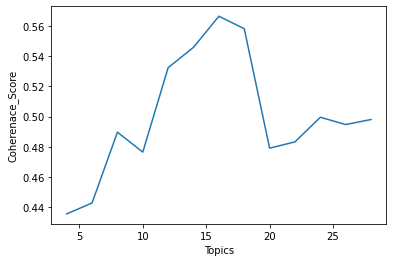

In [67]:
#Plot Results
x = range(4,30,2)
plt.plot(x,coherence_scores)
plt.xlabel('Topics')
plt.ylabel('Coherenace_Score')

In [248]:
print(f'The optimum number of topics is : {x[coherence_scores.index(max(coherence_scores))]}\nHowever, when looking at the topics, only the first 12 are actually distinct so I will opt for 12 Topics')

The optimum number of topics is : 16
However, when looking at the topics, only the first 12 are actually distinct so I will opt for 12 Topics


In [253]:
# Final Model Selection
final_model = models[4]

In [254]:
pprint(final_model.print_topics(num_words=10))

[(0,
  '0.046*"algorithm" + 0.040*"model" + 0.032*"machine_learning" + '
  '0.028*"learning" + 0.022*"feature" + 0.017*"training" + 0.016*"predict" + '
  '0.014*"number" + 0.014*"prediction" + 0.014*"weight"'),
 (1,
  '0.081*"data" + 0.047*"ibm" + 0.033*"analytics" + 0.029*"view" + '
  '0.025*"blog" + 0.018*"big" + 0.017*"developerworks" + 0.017*"spark" + '
  '0.011*"watson" + 0.011*"science"'),
 (2,
  '0.052*"cloudant" + 0.043*"data" + 0.030*"dashdb" + 0.019*"ibm" + '
  '0.016*"database" + 0.015*"window" + 0.013*"app" + 0.013*"share" + '
  '0.011*"pouchdb" + 0.011*"couchdb"'),
 (3,
  '0.035*"science" + 0.021*"address" + 0.020*"rstudio" + 0.018*"feather" + '
  '0.017*"blog" + 0.017*"shiny" + 0.016*"post" + 0.015*"week" + '
  '0.015*"package" + 0.013*"col_col"'),
 (4,
  '0.046*"node" + 0.046*"message" + 0.045*"graph" + 0.026*"restheart" + '
  '0.017*"rabbitmq" + 0.013*"conversation" + 0.011*"watson_conversation" + '
  '0.011*"entity" + 0.011*"recipe" + 0.011*"article"'),
 (5,
  '0.022*"

In [255]:
# Visualize the topics - Nicely spaced out topics.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.162364 -0.070069       1        1  29.764656
5     -0.165427  0.000322       2        1  17.304737
8     -0.168283 -0.164672       3        1  17.106836
10    -0.147120  0.043721       4        1   8.017363
2      0.039686 -0.248368       5        1   6.996108
11    -0.158692  0.178254       6        1   5.855965
0     -0.111196  0.181723       7        1   4.660347
1      0.097857 -0.205216       8        1   4.263412
3      0.212375 -0.016849       9        1   1.909966
9      0.245578  0.041944      10        1   1.572289
4      0.197096  0.102809      11        1   1.346391
7      0.120490  0.156401      12        1   1.201939, topic_info=          Term          Freq         Total Category  logprob  loglift
34        data  21503.000000  21503.000000  Default  30.0000  30.0000
1154   compose   2275.000000   2275.000000  Default  29.0000  29.0000
67         ibm   4052.000000   4052.000000  Default  28.0000  28.0000
2229  cloudant   2461.000000   2461.000000  Default  27.0000  27.0000
131    science   2385.000000   2385.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3068       sum     42.292870    260.447205  Topic12  -5.2544   2.6035
1411      sort     39.017376    159.754623  Topic12  -5.3350   3.0116
666     number     47.349884   1895.093384  Topic12  -5.1414   0.7318
2346  function     41.792500   2393.162842  Topic12  -5.2663   0.3736
621       mean     40.609272   1149.257568  Topic12  -5.2950   1.0784

[811 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
180       1  0.992592     abstract
2160      5  0.993422  abuse_terms
1264      1  0.085041       access
1264      2  0.200696       access
1264      3  0.659916       access
...     ...       ...          ...
1436     10  0.012867         year
3887      2  0.034325         zero
3887      5  0.020595         zero
3887      6  0.332948         zero
3887      7  0.610977         zero

[1743 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 11, 3, 12, 1, 2, 4, 10, 5, 8])

In [ ]:
#Save Model to Pickle File
LDA_Classifier = joblib.dump(final_model, 'LDA_Topic_Classifier.pkl')

In [ ]:
#Classify 12 Prominent Topics
topics = {'TopicId':[x for x in range(12)],'Name':[]}

In [ ]:
topics['Name'] = ['Training_Machine_Learning_Algorithm',
                  'Data_Analytics_IBM_Spark',
                  'Cloudant_Database',
                  'rstudio',
                  'Graph_Theory',
                  'Redis_Database',
                  'DataScience_MachineLearning',
                  'EDA_Aggregating_Data',
                  'IBM_Watson',
                  'MongoDB_Database',
                  'Python_Pandas',
                  'Undefined']

In [343]:
# Create topics dataframe and save df
topics_df = pd.DataFrame.from_dict(topics)
topics_df.to_csv('Topics_df.csv')

# Build function to classify new documents

In [335]:
def new_word_topic_assignment(text, model=final_model, topics=topics['Name']):
    '''
    args: (str) text: text to be classified
          (model) model: lda model
          (list) topics: topics classified by lda
    
    returns: (str) Most relevant topic based on LDA model, (float) Perc Contribution
       
    '''
    #Preprocess text
    text = [text]
    data = list(sent_to_words(text))
    data = remove_stopwords(data)
    data = make_bigrams(data)
    data = lemmatization(data)
    data = id2word.doc2bow(data[0])
    
    #Classify Text
    top_topic = sorted(model[data][0], key=lambda x: x[1], reverse=True)[0]
    
    return topics[top_topic[0]], top_topic[1]

In [300]:
dom_topic = []
perc_cont = []
for doc in corpus:
    temp = sorted(final_model[doc][0], key=lambda x: x[1], reverse=True)
    dom_topic.append(temp[0][0])
    perc_cont.append(temp[0][1])

df['Topic_id'] = dom_topic
df['Topic_Perc_Contribution'] = perc_cont
df['Topic_Name'] = df['Topic_id'].apply(lambda x: topics['Name'][x])

In [301]:
df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,Topic_id,Topic_Perc_Contribution,Topic_Name
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,1,0.693845,Data_Analytics_IBM_Spark
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,6,0.870866,DataScience_MachineLearning
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,6,0.593603,DataScience_MachineLearning
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,9,0.477885,MongoDB_Database
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,1,0.814805,Data_Analytics_IBM_Spark


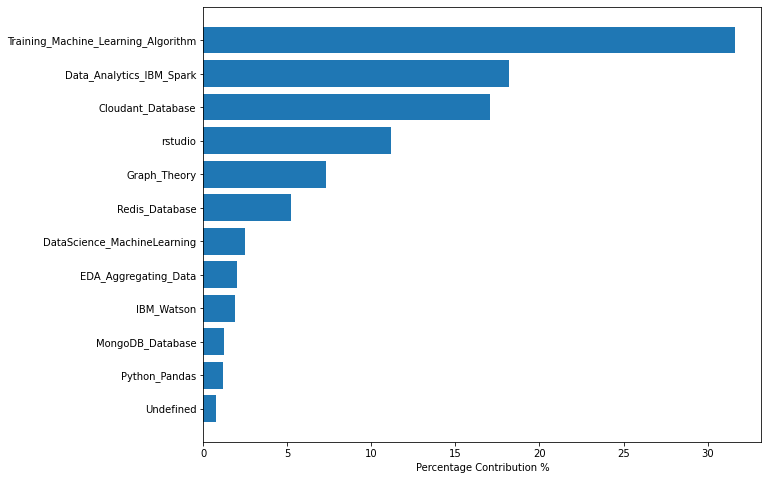

In [299]:
# Contribution of Topics
plt.figure(figsize=[10,8])
plt.barh(np.arange(12),sorted(df.Topic_id.value_counts().values/df.Topic_id.value_counts().sum()*100,reverse=False))
plt.xlabel('Percentage Contribution %')
plt.yticks(ticks=np.arange(12),labels=topics['Name'][::-1]);

In [302]:
# Export new dataframe to build content based recommendation engine
df.to_csv('articles_community_classified.csv')

In [336]:
test = 'Hyperparameters'

new_word_topic_assignment(test)

('Training_Machine_Learning_Algorithm', 0.32361844)

In [337]:
def topic_assignment(text, model=final_model, topics=topics['Name']):
    '''
    args: (str) text: text to be classified
          (model) model: lda model
          (list) topics: topics classified by lda
    
    returns: (list)(tuples): Descending List of tuples: [((int) Most relevant topic based on LDA model, (float) Perc Contribution)]
       
    '''
    #Preprocess text
    text = [text]
    data = list(sent_to_words(text))
    data = remove_stopwords(data)
    data = make_bigrams(data)
    data = lemmatization(data)
    data = id2word.doc2bow(data[0])
    
    #Classify Text
    top_topic = sorted(model[data][0], key=lambda x: x[1], reverse=True)
    
    return top_topic

In [338]:
test = 'Hyperparameters'

topic_assignment(test)

[(0, 0.3236184),
 (6, 0.18767619),
 (8, 0.14280437),
 (5, 0.1068512),
 (10, 0.05758384),
 (2, 0.04804404),
 (11, 0.042228118),
 (1, 0.024340106),
 (3, 0.021326061),
 (9, 0.017349908),
 (4, 0.016449893),
 (7, 0.011727865)]

In [339]:
df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,Topic_id,Topic_Perc_Contribution,Topic_Name
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,1,0.693845,Data_Analytics_IBM_Spark
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,6,0.870866,DataScience_MachineLearning
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,6,0.593603,DataScience_MachineLearning
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,9,0.477885,MongoDB_Database
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,1,0.814805,Data_Analytics_IBM_Spark


### References
[1] [Topic Modeling with Python Gensim Library](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)  

In [333]:
#Preprocess text
text = test
text = [text]
data = list(sent_to_words(text))
data = remove_stopwords(data)
data = make_bigrams(data)
data = lemmatization(data)
data = id2word.doc2bow(data[0])

#Classify Text
top_topic = sorted(final_model[data][0], key=lambda x: x[1], reverse=True)

In [ ]:
df